In [1]:
from lib.clip_utils import CLIPModel
from gen.clip_guided import generate_w_clip
from gen.rsp_sampling import rsp_sampling
from lib.utils import set_seed, load_model
from PIL import Image
from matplotlib import pyplot as plt


model_name = 'llava_v1_5'
model_type = '7b'

# model_name = 'mplug_owl2'
# model_type = 'llama2-7b'

# model_name = 'blip2_vicuna_instruct'
# model_type = 'vicuna7b'

device = 'cuda:0'



In [2]:
print('begin loading model')
model, vis_processor, tokenizer = load_model(model_name=model_name, model_type=model_type, device=device)
model.eval()
print('end loading model')

clip_scorer = CLIPModel(device=device)

begin loading model


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

end loading model


In [3]:
if model_name == 'llava_v1_5':
    text = "<image>\nDescribe this image in detail."
elif model_name == 'blip2_vicuna_instruct':
    text = "Describe this image in detail."
elif model_name == 'mplug_owl2':
    text = "<|image|>Describe this image in detail.\n"

In [4]:
args = {
    'model_name': model_name,
    'model_type': model_type,
    'algo_name': 'sentence_clip',
    'sampling_params': {
        'temperature': 0.2,
        'top_p': 1,
        'top_k': 5, # added
        'num_beams': 1,
        'do_sample': True,
        'num_return_sequences': 3,
        'max_new_tokens': 500,
    },
    'scoring': {
        'alpha': 0.01, # prob
        'beta': 1, # clip
        'prob_type': 'lennorm_sum_log',
        'max_cand_num': 3
    }
}


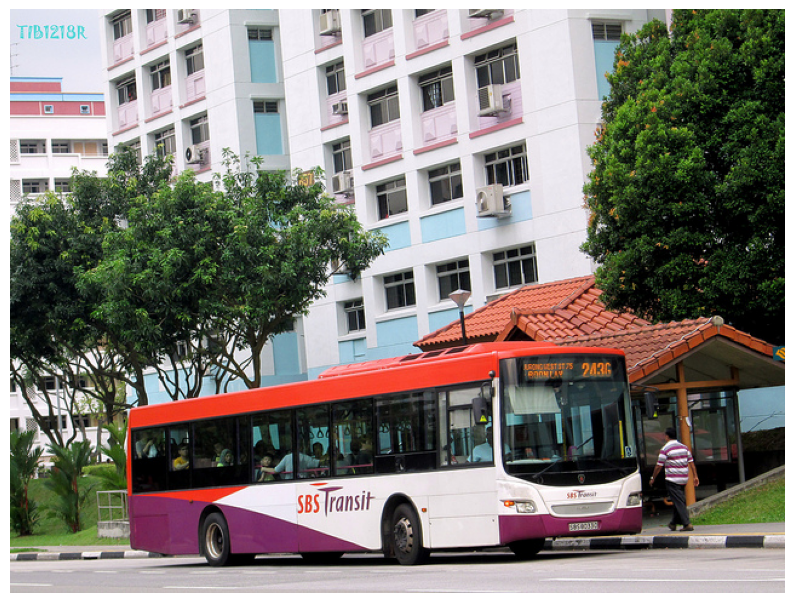

Top-k Sampling:
The image features a red and white bus driving down a street in a city. The bus is positioned in the middle of the scene, and it appears to be turning a corner. There are several people visible on the street, some walking and others standing.

In addition to the bus, there are two cars in the scene. One car is located on the left side of the image, while the other car is on the right side. The presence of these vehicles indicates that the street is a busy urban area.
--------------------------------------------------
(Ours) CLIP-Guided Decoding:
The image features a large red and white bus driving down a street, likely in a city. The bus is positioned in the middle of the scene, and it appears to be the main focus of the image. 

There are several people visible around the bus, with some standing closer to the bus and others further away. One person is standing near the front of the bus, while others are scattered throughout the scene. The presence of these individuals 

In [20]:
# image_id = '480720'
image_id = '075600'
image_path = './assets/COCO_val2014_000000{}.jpg'.format(image_id)
image = Image.open(image_path).convert("RGB")

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

set_seed(0)
all_generated_str = rsp_sampling(model, tokenizer, vis_processor, text, image, device=device, verbose=False, final_res_num=1, 
                                 args={**args, 'sampling_params': {**args['sampling_params'], 'num_return_sequences': 1}})
print('Top-k Sampling:')
print(all_generated_str[0])

set_seed(0)
all_generated_str = generate_w_clip(model, tokenizer, vis_processor, text, image, device=device, verbose=False, final_res_num=1, args=args,
                                                                 return_max_probs=True, return_clip_scores=True, clip_scorer=clip_scorer)
print('-'*50)
print('(Ours) CLIP-Guided Decoding:')
print(all_generated_str[0])